In [1]:
# Importing necessary libraries
!pip install folium geopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime #Converting my abreviated dates in the when column to full text

In [2]:
# Load your dataset
data = pd.read_csv("cleanedBoatModels.csv")
data.set_index("Boat Name", inplace=True)

# Extract numbers and potential 'm' (for meters) from the 'Boat Model' column
numbers = data['Boat Model'].str.extract(r'(\d+\.?\d*)(m)?$', expand=True) # regular expression pattern.
numbers.columns = ['number', 'unit'] # This is a list of new column names.
# Renaming the first column (which contains the extracted numbers) to "number

# Convert numbers with 'm' to feet (1 meter = 3.281 feet)
# This is a way of indexing or selecting specific rows in a DataFrame using the boolean mask. 
# It selects all the rows where the mask is True for the 'number' column
mask = numbers['unit'] == 'm'
numbers.loc[mask, 'number'] = (numbers.loc[mask, 'number'].astype(float) * 3.281).astype(int).astype(str)

# Round down any decimals and ensure every number is two digits
# This code rounds down any numbers with decimals by splitting the string at the decimal point and taking only the integer part.
# ensures that each number is at most two digits long
numbers['number'] = numbers['number'].str.split('.').str[0].str[:2]

# Replace the original numbers in the 'Boat Model' column with the processed numbers
data['Boat Model'] = data['Boat Model'].str.replace(r'\d+\.?\d*m?$', '', regex=True).str.strip() + " " + numbers['number'].fillna('')

# Create a new column 'Length(ft)' and copy the two-digit numbers to it, appending "ft"
data['Length(ft)'] = numbers['number']
data.info()

# For blank boat models, set the corresponding lengths to NaN
#For blank boat models, set the corresponding lengths to NaN
# Using the `.loc` accessor of the pandas DataFrame to select rows and columns based on conditions.
# The code aims to modify the 'Length(ft)' column for rows where 'Boat Model' is blank.
# Using the boolean mask, this targets rows with blank 'Boat Model' and the 'Length(ft)' column.
data.loc[data['Boat Model'].str.strip() == '', 'Length(ft)'] = np.nan

# Reorder the columns
data = data[['Boat Model', 'Length(ft)', 'Homeport', "Owner's Name", 'Departing From', 'When', 'Year']]

print(data.head())


# Remove trailing, leading, and extra white spaces in between words for all columns
# Replace any sequences of multiple white spaces with a single space using the regular expression r'\s+'
for column in data.columns:
    data[column] = data[column].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)

# Display the updated DataFrame
print(data)

<class 'pandas.core.frame.DataFrame'>
Index: 641 entries, Aloha Toa to Zatara
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Boat Model      640 non-null    object
 1   Homeport        641 non-null    object
 2   Owner's Name    641 non-null    object
 3   Departing From  637 non-null    object
 4   When            637 non-null    object
 5   Year            641 non-null    int64 
 6   Length(ft)      614 non-null    object
dtypes: int64(1), object(6)
memory usage: 40.1+ KB
                      Boat Model Length(ft)            Homeport  \
Boat Name                                                         
Aloha Toa        Wharram Tiki 30         30              La Paz   
Ana Maria    Pacific Seacraft 34         34         Seattle, WA   
Arctic Tern     Island Packet 40         40          Kailua, HI   
Beleza                  Hylas 46         46       Hermosa Beach   
Best Life             Leopard 47         

In [3]:
def process_date(value):
    # If value is NaN or blank, return NaN
    if pd.isna(value) or value.strip() == "":
        return np.NaN

    # Convert abbreviated month names to full names
    try:
        value = datetime.strptime(value, '%b').strftime('%B')
    except:
        pass

    # If value contains "/", extract the first month
    if "/" in value:
        month = re.search(r'(January|February|March|April|May|June|July|August|September|October|November|December)', value)
        if month:
            return month.group(1)
        # The group() method of a match object allows you to access the portions of the matched text
        
                # If value contains "First Week of", "2nd week of", etc., extract the month after these words
    week_match = re.search(r'(First Week of|2nd week of|2nd Week of) ([A-Za-z]+)', value)
    if week_match:
        return week_match.group(2)

    # If value is in the format "15-Apr", extract "Apr" and convert to "April"
    if re.match(r'\d{1,2}-[A-Za-z]{3}', value):
        day, month_abbr = value.split('-')
        month_full = datetime.strptime(month_abbr, '%b').strftime('%B')
        return f"{month_full} {day}"
    
    # If value contains "Late", "Early", "Mid", "Start of", "Beginning of", or "End of", extract the month after these words
    # f the value contains descriptive phrases like "Late", "Early", etc., it tries to find a full month name after these phrases and returns it.
    elif any(keyword in value for keyword in ["Late", "Early", "Mid", "Start of", "Beginning of", "End of"]):
        month = re.search(r'(January|February|March|April|May|June|July|August|September|October|November|December)', value)
        if month:
            return month.group(1)
    
    # If value contains "About" or "approx.", extract the month after these words
    elif any(keyword in value for keyword in ["About", "approx."]):
        month = re.search(r'(January|February|March|April|May|June|July|August|September|October|November|December)', value)
        if month:
            return month.group(1)
    
    # If value contains multiple dates separated by "-", ";", or "or", extract the first month
    # f the value contains multiple dates separated by "-", ";", or "or", it tries to find the first full month name and returns it.
    elif any(separator in value for separator in ["-", ";", "or"]):
        month = re.search(r'(January|February|March|April|May|June|July|August|September|October|November|December)', value)
        if month:
            return month.group(1)
    
    # If value contains a specific day range like "June 8-9", extract the first day
    day_range_match = re.match(r'([A-Za-z]+) (\d{1,2})-\d{1,2}', value)
    if day_range_match:
        month, day = day_range_match.groups()
        return f"{month} {day}"
    
 
    # If value is just a month name, return it
    elif re.match(r'^[A-Za-z]+$', value):
        return value
    
    # Return original value if none of the above conditions are met
    return value

# Apply the function to the 'When' column
data['When'] = data['When'].apply(process_date)

# Display the modified DataFrame
print(data['When'])
data.head()


Boat Name
Aloha Toa         April 5
Ana Maria        February
Arctic Tern      April 15
Beleza              March
Best Life         March 8
                  ...    
Windsong         April 21
Wiz                 April
Xirene         February 1
Y2K                 March
Zatara           April 15
Name: When, Length: 641, dtype: object


,Boat Model,Length(ft),Homeport,Owner's Name,Departing From,When,Year
Boat Name,,,,,,,
Aloha Toa,Wharram Tiki 30,30,La Paz,Tymoteo Shaddock,Baja,April 5,2023
Ana Maria,Pacific Seacraft 34,34,"Seattle, WA",Andres & Katherine Gonzalez,La Paz,February,2023
Arctic Tern,Island Packet 40,40,"Kailua, HI",Shaen & Laura Tarter,"Honolulu, HI",April 15,2023
Beleza,Hylas 46,46,Hermosa Beach,Christopher Maler,Cabo San Lucas,March,2023
Best Life,Leopard 47,47,"Salt Lake City, UT",Benjamin Fletcher,Puerto Vallarta,March 8,2023


In [4]:
# Create a DataFrame
#df = pd.DataFrame(data, columns=["Departing From"])

# Define a dictionary for replacements and corrections
replacements = {
    "La Paz": "La Paz, Mexico",
    "Baja":"Baja, Mexico",
    "San Francisco": "San Francisco, USA",
    "Nuevo Vallarta": "Nuevo Vallarta, Mexico",
    "Bandaras Bay": "Banderas Bay, Mexico",
    "La  Paz": "La Paz, Mexico",
    "Panana": "Panama",
    "Panama then Galapagos": "Panama",
    "Panama or Equador": "Panama",
    "nan": "Unknown",
    "TBD": "Unknown",
    "Ensenada, MX": "Ensenada, Mexico",
    "La Cruz, PV": "La Cruz, Mexico",
    "Panama via Galapagos": "Panama",
    "Most likely La Paz": "La Paz, Mexico",
    "Hilo, HI": "Hilo, Hawaii, USA",
    "PV or Cabo": "Puerto Vallarta, Mexico",
    "San Diego or Port Hueneme": "San Diego, USA",
    "San Diego":"San Diego, USA",
    "Mexico or Panama/Galapagos": "Mexico",
    "Panama & Galapagos": "Panama",
    "Panama canal": "Panama Canal",
    "Zihuatenejo or PV": "Zihuatenejo, Mexico",
    "Panama or Ecuador": "Panama",
    "La Paz or Puerto Vallarta": "La Paz, Mexico",
    "Puerto Vallarta, MEX": "Puerto Vallarta, Mexico",
    "Puerto Vallarta MX": "Puerto Vallarta, Mexico",
    "Bahia De Caraquez / Ecuador": "Bahia De Caraquez, Ecuador",
    "Curaçao": "Curaçao, Netherlands",
    "Honolulu, HI": "Honolulu, Hawaii, USA",
    "Cabo San Lucas": "Cabo San Lucas, Mexico",
    "Lahaina, HI": "Lahaina, Hawaii, USA",
    "Banderas Bay": "Banderas Bay, Mexico",
    "Whangarei, NZ": "Whangarei, New Zealand",
    "Ventura, CA": "Ventura, California, USA",
    "Hawaii": "Hawaii, USA",
    "Balboa, Panama": "Balboa, Panama",
    "Valdivia, Chile": "Valdivia, Chile",
    "Zihuatanejo": "Zihuatanejo, Mexico",
    "Titusville, FL": "Titusville, Florida, USA",
    "Isla Socorro, MEX": "Isla Socorro, Mexico",
    "Bora Bora": "Bora Bora, French Polynesia",
    "Easter Island": "Easter Island, Chile",
    "Golfito, Costa Rica": "Golfito, Costa Rica",
    "Port Townsend, WA": "Port Townsend, Washington, USA",
    "Oceanside, CA": "Oceanside, California, USA",
    "Mag Bay, Mexico": "Mag Bay, Mexico",
    "La Paz (Baja Sur)": "La Paz, Baja California Sur, Mexico",
    "San Jose del Cabo": "San Jose del Cabo, Mexico",
    "La Cruz": "La Cruz, Mexico",
    "Newport Beach": "Newport Beach, California, USA",
    "Barra de Navidad": "Barra de Navidad, Mexico",
    "La Cruz, MEX" : "La Cruz, Mexico",
    "La Paz, Baja California Sur, Mexico":"La Paz, Mexico",
    "Galapagos, Santa Cruz": "Galapagos, Ecuador",
    "Galapagos": "Galapagos, Ecuador",
    "Panama/Galapagos":"Panama",
    "Chile (Valparasio, then Easter Island)": "Valparaíso, Chile",
    "Panama Canal" : "Panama Canal, Panama",
    "Puerto Madero, Chiapas, MEX":"Puerto Madero, Mexico"
}


# Apply replacements loop through the dictionary and update each. 
data["Departing From"] = data["Departing From"].replace(replacements)

# Display cleaned data
print(data)



                      Boat Model Length(ft)                Homeport  \
Boat Name                                                             
Aloha Toa        Wharram Tiki 30         30                  La Paz   
Ana Maria    Pacific Seacraft 34         34             Seattle, WA   
Arctic Tern     Island Packet 40         40              Kailua, HI   
Beleza                  Hylas 46         46           Hermosa Beach   
Best Life             Leopard 47         47      Salt Lake City, UT   
...                          ...        ...                     ...   
Windsong                   CT 47         47            Portland, OR   
Wiz                      Swan 44         44             Seattle, WA   
Xirene         X-Yachts X-482 48         48         Muiderzand, NED   
Y2K          Beneteau Oceanis 50         50  Marina di Carrara, ITA   
Zatara       Beneteau Oceanis 55         55            Montana, USA   

                            Owner's Name          Departing From        When

In [5]:
# Create a DataFrame
#df = pd.DataFrame(data, columns=["Homeport"])

# Define a dictionary for replacements and corrections
replacements_homeport = {
    "Panana": "Panama",
    "La Paz": "La Paz, MEX",
    "San Diego": "San Diego, CA",
    "Ensenada": "Ensenada, MEX",
    "La Cruz": "La Cruz, MEX",
    "Puerto Vallarta": "Puerto Vallarta, MEX",
    "Cabo San Lucas": "Cabo San Lucas, MEX",
    "Zihuatanejo": "Zihuatanejo, MEX",
    "MEX": "Mexico",
    "nan": "Unknown",
    "TBD": "Unknown",
    "None": "Unknown",
    "Not Provided": "Unknown",
    "Texas": "Texas, USA",  # This is a guess, as Texas is a state and not a city
    "Delaware": "Delaware, USA",  # This is a guess, as Delaware is a state and not a city
    "Colorado": "Colorado, USA",  # This is a guess, as Colorado is a state and not a city
    "Montana": "Montana, USA",  # This is a guess, as Montana is a state and not a city
    "Marc & Angela Johnson": "Unknown",  # This seems to be a name and not a location
}

# Apply replacements
#df["Homeport"] = df["Homeport"].replace(replacements_homeport)

# Apply replacements with a lambda function for more flexibility
data["Homeport"] = data["Homeport"].apply(lambda x: replacements_homeport.get(x, x))

# Display cleaned data
print(data)



                      Boat Model Length(ft)                Homeport  \
Boat Name                                                             
Aloha Toa        Wharram Tiki 30         30             La Paz, MEX   
Ana Maria    Pacific Seacraft 34         34             Seattle, WA   
Arctic Tern     Island Packet 40         40              Kailua, HI   
Beleza                  Hylas 46         46           Hermosa Beach   
Best Life             Leopard 47         47      Salt Lake City, UT   
...                          ...        ...                     ...   
Windsong                   CT 47         47            Portland, OR   
Wiz                      Swan 44         44             Seattle, WA   
Xirene         X-Yachts X-482 48         48         Muiderzand, NED   
Y2K          Beneteau Oceanis 50         50  Marina di Carrara, ITA   
Zatara       Beneteau Oceanis 55         55            Montana, USA   

                            Owner's Name          Departing From        When

In [6]:
# Split the 'Departing From' column by commas
#split_columns = data['Departing From'].str.split(',', expand=True)

# Rename the new columns for clarity
#split_columns.columns = ['Location1', 'Location2', 'Location3']

# Concatenate the new columns to the right of the 'Departing From' column
#data = pd.concat([data, split_columns], axis=1)

#print(data)


In [7]:
data.to_csv('corrected.csv')

In [8]:
# Extract the boat make from the 'Boat Model' column
data['Boat Make'] = data['Boat Model'].str.split().str[0]

# Most common boat Make/Model (All and by Year):
# All
most_common_model_all = data['Boat Model'].mode().iloc[0]
# By Year
most_common_model_by_year = data.groupby('Year')['Boat Model'].apply(lambda x: x.mode().iloc[0])

# All
most_common_make_all = data['Boat Make'].value_counts().idxmax()
# By Year
most_common_make_by_year = data.groupby('Year')['Boat Make'].apply(lambda x: x.value_counts().idxmax())

# Filter the data for the most common make
filtered_data = data[data['Boat Make'] == most_common_make_all]
# All
most_common_model_for_make_all = filtered_data['Boat Model'].value_counts().idxmax()
# By Year
most_common_model_for_make_by_year = filtered_data.groupby('Year')['Boat Model'].apply(lambda x: x.value_counts().idxmax())

# Most common Boat Length (All and by Year):
# All
most_common_length_all = data['Length(ft)'].mode().iloc[0]
# By Year
most_common_length_by_year = data.groupby('Year')['Length(ft)'].apply(lambda x: x.mode().iloc[0])

# Top 5 Departing From Locations (All and by Year):
# All
top_5_locations_all = data['Departing From'].value_counts().head(5)
# By Year
top_5_locations_by_year = data.groupby('Year')['Departing From'].apply(lambda x: x.value_counts().head(5))

# Bottom 5 Departing From Locations (All and by Year):
# All
bottom_5_locations_all = data['Departing From'].value_counts().tail(5)
# By Year
bottom_5_locations_by_year = data.groupby('Year')['Departing From'].apply(lambda x: x.value_counts().tail(5))


In [9]:
print(data.columns)


Index(['Boat Model', 'Length(ft)', 'Homeport', 'Owner's Name',
       'Departing From', 'When', 'Year', 'Boat Make'],
      dtype='object')


In [10]:
print(most_common_model_all)

Leopard 46


In [11]:
print(most_common_model_for_make_all)

Beneteau 47


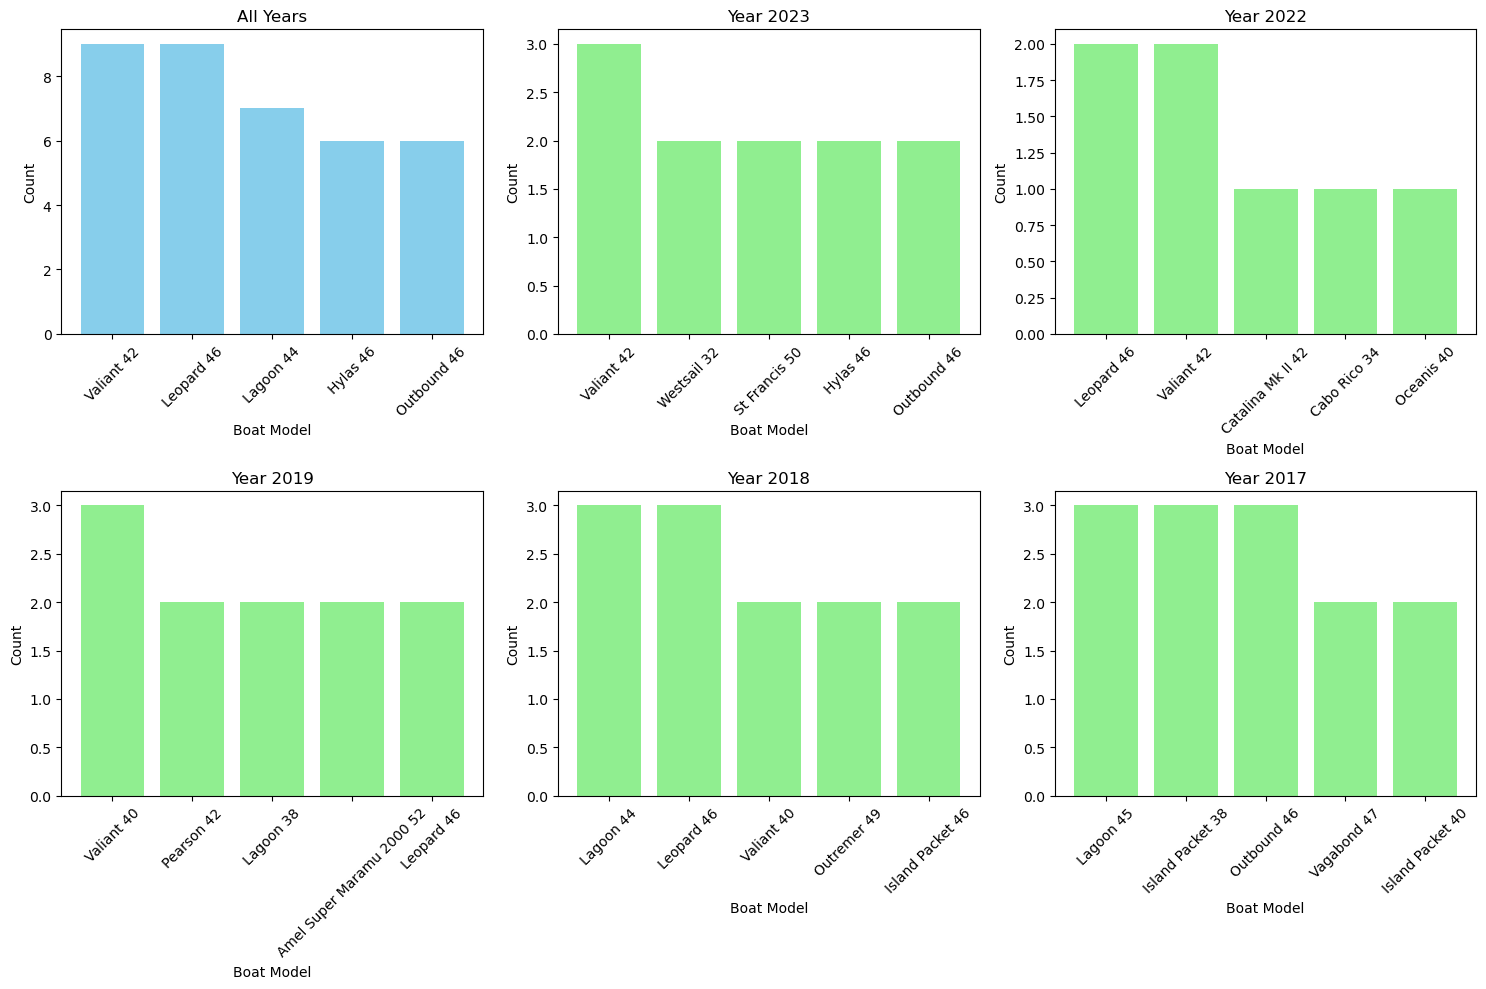

In [12]:
import matplotlib.pyplot as plt

# Extract unique years from the 'Year' column
unique_years = data['Year'].unique()

plt.figure(figsize=(15, 10))

# Plot for the entire dataset
plt.subplot(2, 3, 1)  # 2 rows, 3 columns, 1st plot
boat_models_all = data['Boat Model'].value_counts().index.tolist()[:5]
counts_all = data['Boat Model'].value_counts().tolist()[:5]
plt.bar(boat_models_all, counts_all, color='skyblue')
plt.xlabel('Boat Model')
plt.ylabel('Count')
plt.title('All Years')
plt.xticks(rotation=45)

# Plot for each year
for i, year in enumerate(unique_years, 2):  # Start from the 2nd subplot
    plt.subplot(2, 3, i)
    yearly_data = data[data['Year'] == year]
    boat_models_yearly = yearly_data['Boat Model'].value_counts().index.tolist()[:5]
    counts_yearly = yearly_data['Boat Model'].value_counts().tolist()[:5]
    
    # Only plot if there's data for the year
    if counts_yearly:
        plt.bar(boat_models_yearly, counts_yearly, color='lightgreen')
        plt.xlabel('Boat Model')
        plt.ylabel('Count')
        plt.title(f'Year {year}')
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



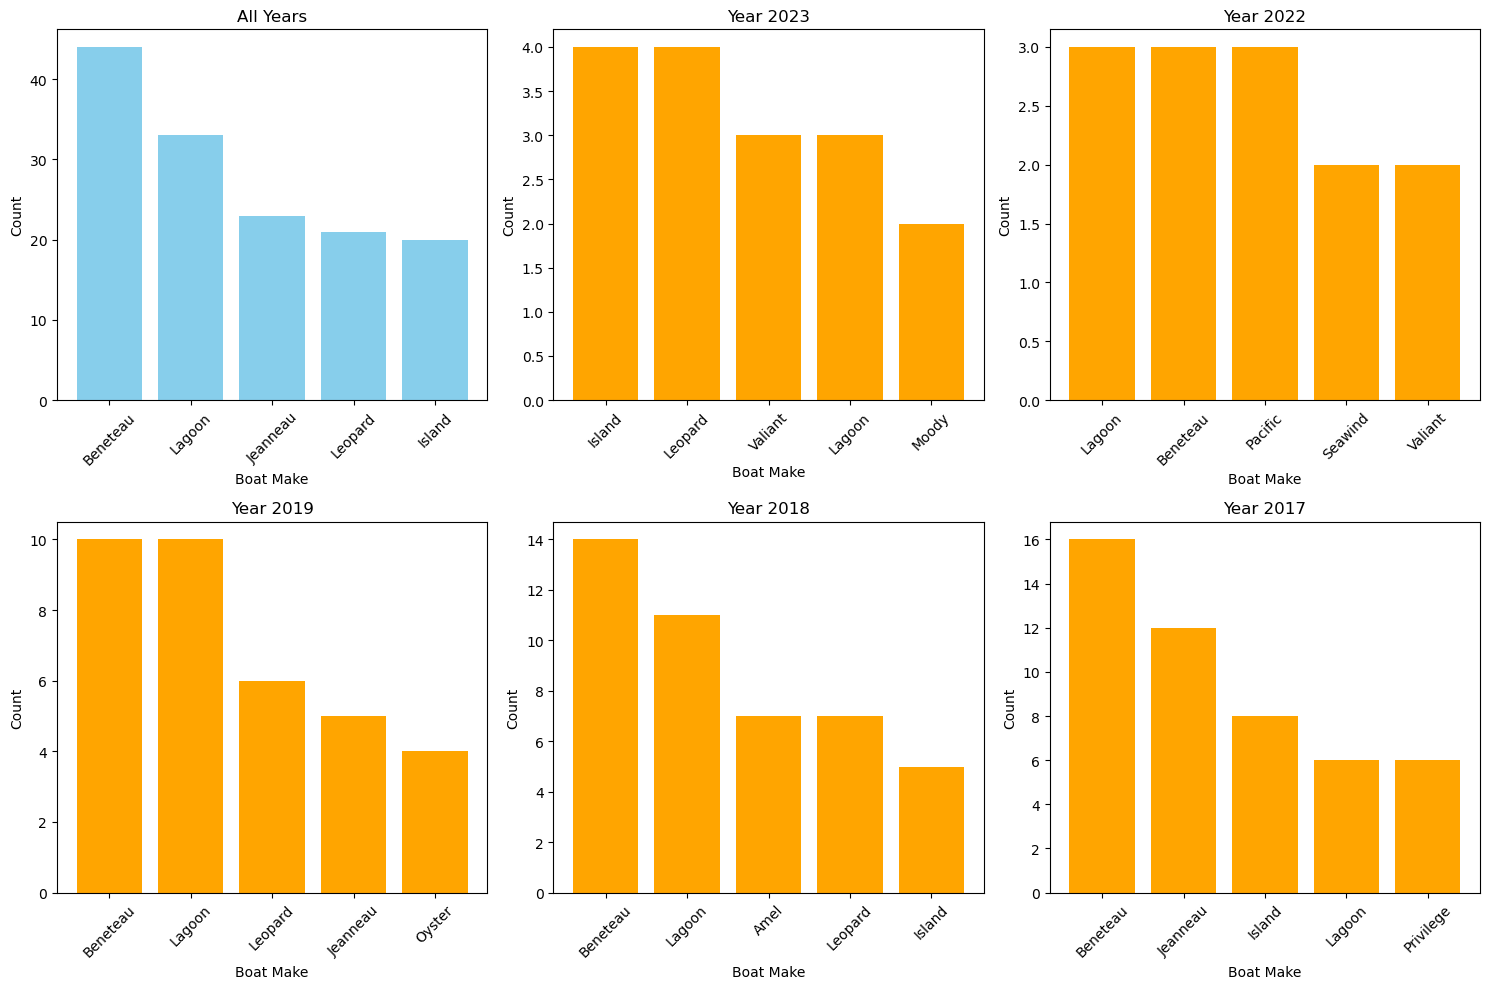

In [13]:
# Most Common Boat Make/Model for all data

# Extract unique years from the 'Year' column
unique_years = data['Year'].unique()

plt.figure(figsize=(15, 10))

# Plot for the entire dataset
plt.subplot(2, 3, 1)  # 2 rows, 3 columns, 1st plot
boat_models_all = data['Boat Make'].value_counts().index.tolist()[:5]
counts_all = data['Boat Make'].value_counts().tolist()[:5]
plt.bar(boat_models_all, counts_all, color='skyblue')
plt.xlabel('Boat Make')
plt.ylabel('Count')
plt.title('All Years')
plt.xticks(rotation=45)

# Plot for each year
for i, year in enumerate(unique_years, 2):  # Start from the 2nd subplot
    plt.subplot(2, 3, i)
    yearly_data = data[data['Year'] == year]
    boat_models_yearly = yearly_data['Boat Make'].value_counts().index.tolist()[:5]
    counts_yearly = yearly_data['Boat Make'].value_counts().tolist()[:5]
    
    # Only plot if there's data for the year
    if counts_yearly:
        plt.bar(boat_models_yearly, counts_yearly, color='orange')
        plt.xlabel('Boat Make')
        plt.ylabel('Count')
        plt.title(f'Year {year}')
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [25]:
# Convert the 'Length(ft)' column to numeric, handling any errors
data['Length(ft)'] = pd.to_numeric(data['Length(ft)'], errors='coerce')

# Now, let's compute the statistics
max_length = data['Length(ft)'].max()
min_length = data['Length(ft)'].min()
mean_length = data['Length(ft)'].mean()
mode_length = data['Length(ft)'].mode().iloc[0]

print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")
print(f"Mean Length: {mean_length:.2f}")
print(f"Mode Length: {mode_length}")




Max Length: 97.0
Min Length: 10.0
Mean Length: 44.01
Mode Length: 42.0


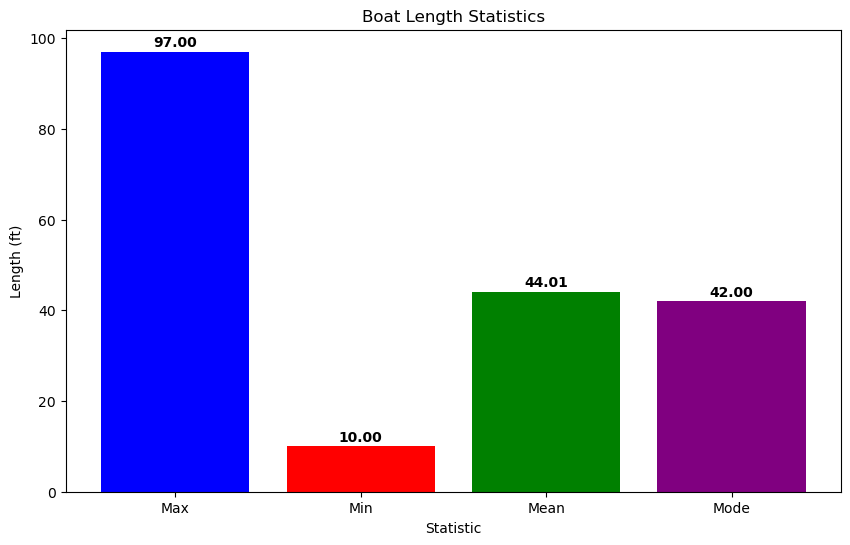

In [26]:
# Values
values = [max_length, min_length, mean_length, mode_length]
labels = ['Max', 'Min', 'Mean', 'Mode']

# Create bar chart
plt.figure(figsize=(10,6))
plt.bar(labels, values, color=['blue', 'red', 'green', 'purple'])
plt.title('Boat Length Statistics')
plt.ylabel('Length (ft)')
plt.xlabel('Statistic')
for i, v in enumerate(values):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
plt.show()


In [34]:
# Group by the 'Month' column and get the count of each month
month_counts = data.groupby('Month').size().sort_values(ascending=False)

# Most and least common months using groupby
most_common_month = month_counts.index[0]
second_most_common_month = month_counts.index[1]

least_common_month = month_counts.index[-1]
second_least_common_month = month_counts.index[-2]

print(f"Most common month: {most_common_month}")
print(f"Second most common month: {second_most_common_month}")
print(f"Least common month: {least_common_month}")
print(f"Second least common month: {second_least_common_month}")



Most common month: March
Second most common month: April
Least common month: September
Second least common month: October


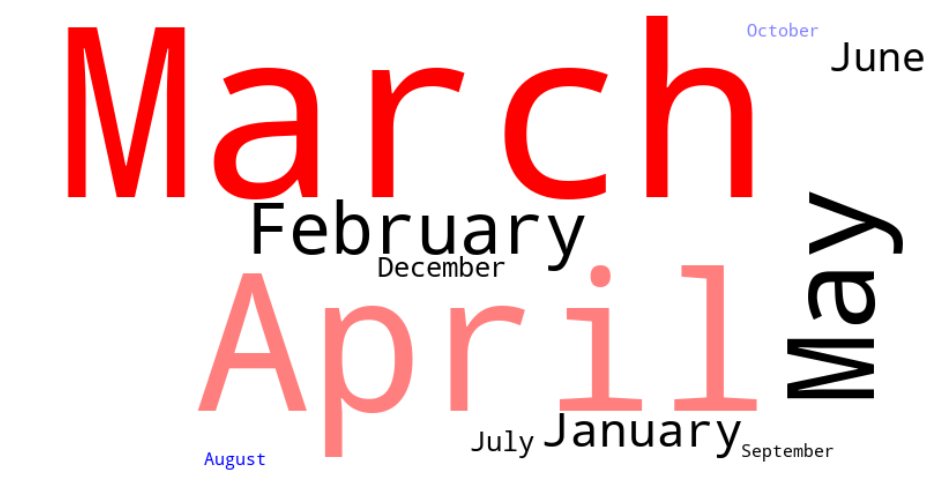

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary of month frequencies
month_freq = month_counts.to_dict()

# Define a custom color function
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word == most_common_month:
        return "red"
    elif word == second_most_common_month:
        return "#FF7F7F"
    elif word == least_common_month:
        return "blue"
    elif word == second_least_common_month:
        return "#7F7FFF"
    else:
        return "black"

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="tab10", color_func=custom_color_func).generate_from_frequencies(month_freq)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


NameError: name 'soup' is not defined